<a href="https://colab.research.google.com/github/Saponjyan/CV/blob/main/stable_diffusion_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install --quiet --upgrade diffusers transformers accelerate mediapy triton scipy ftfy spacy==3.4.4


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 89.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 26.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 39.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 70.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 42.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour 

In [2]:
# The xformers package is mandatory to be able to create several 768x768 images.
%pip install -q xformers==0.0.16rc425

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.5/887.5 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 54.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.0.2+cu118 requires torch==2.0.1, but you have torch 1.13.1 which is incompatible.
torchdata 0.6.1 requires torch==2.0.1, but you have torch 1.13.1 which is incompatible.
torchtext 0.15.2 requires torch==2.0.1, but you have torch 1.13.1 which is incompatible.
torchvision 0.15.2+cu118 requires torch==2.0.1, but you have torch 

In [3]:
# model_id = "stabilityai/stable-diffusion-2-1-base"
# model_id = "stabilityai/stable-diffusion-2-1"
model_id = "dreamlike-art/dreamlike-photoreal-2.0"

In [4]:
from diffusers import PNDMScheduler, DDIMScheduler, LMSDiscreteScheduler, EulerDiscreteScheduler, DPMSolverMultistepScheduler

scheduler = None
# scheduler = PNDMScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = DDIMScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = LMSDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
# scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")

In [5]:

import mediapy as media
import torch
from diffusers import StableDiffusionPipeline
import random

device = "cuda"

if model_id.startswith("stabilityai/"):
  model_revision = "fp16"
else:
  model_revision = None

if scheduler is None:
  pipe = StableDiffusionPipeline.from_pretrained(
      model_id,
      torch_dtype=torch.float16,
      revision=model_revision,
      )
else:
  pipe = StableDiffusionPipeline.from_pretrained(
      model_id,
      scheduler=scheduler,
      torch_dtype=torch.float16,
      revision=model_revision,
      )

pipe = pipe.to(device)
pipe.enable_xformers_memory_efficient_attention()

if model_id.endswith('-base'):
  image_length = 512
else:
  image_length = 768

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]


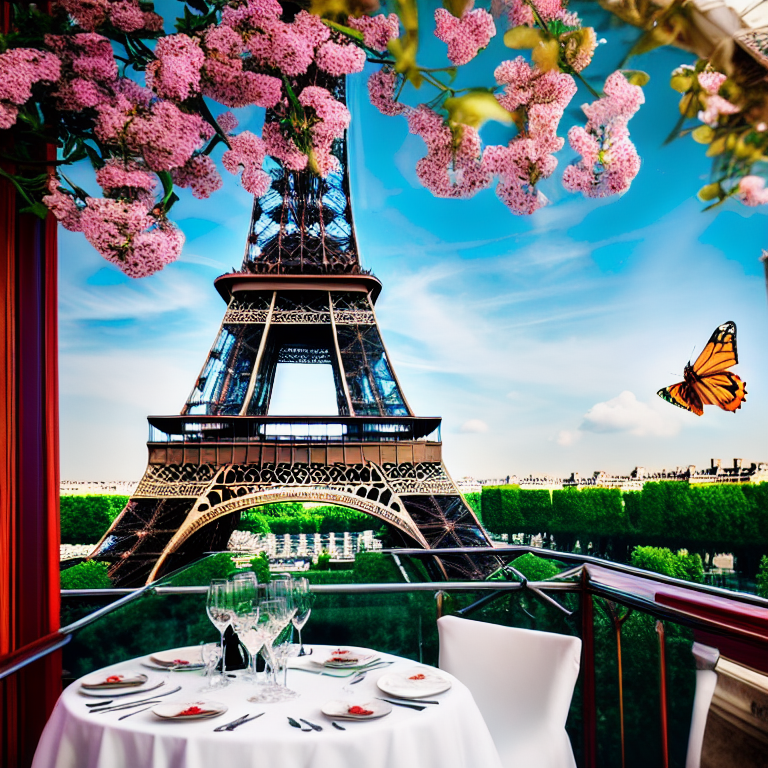
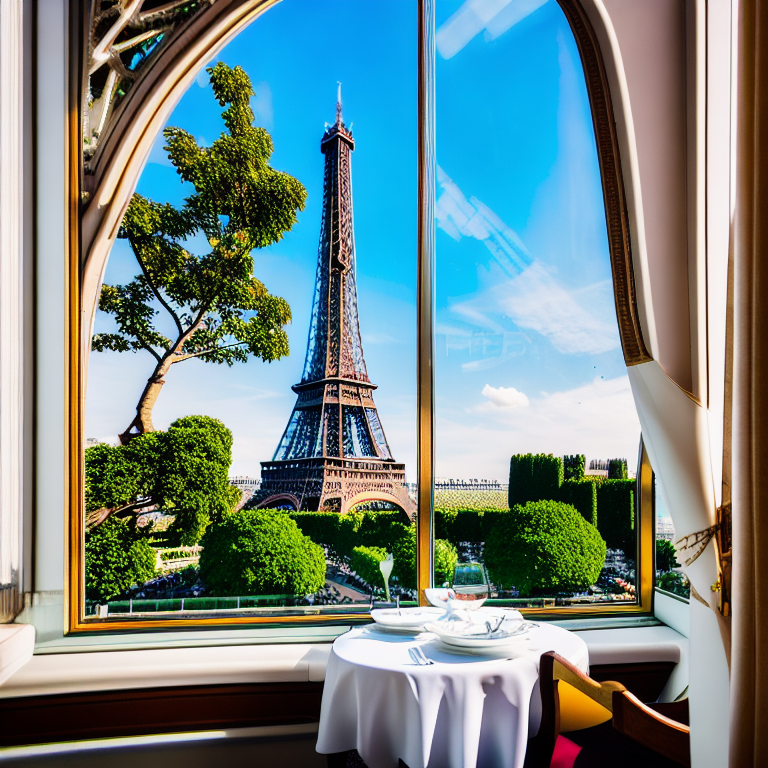
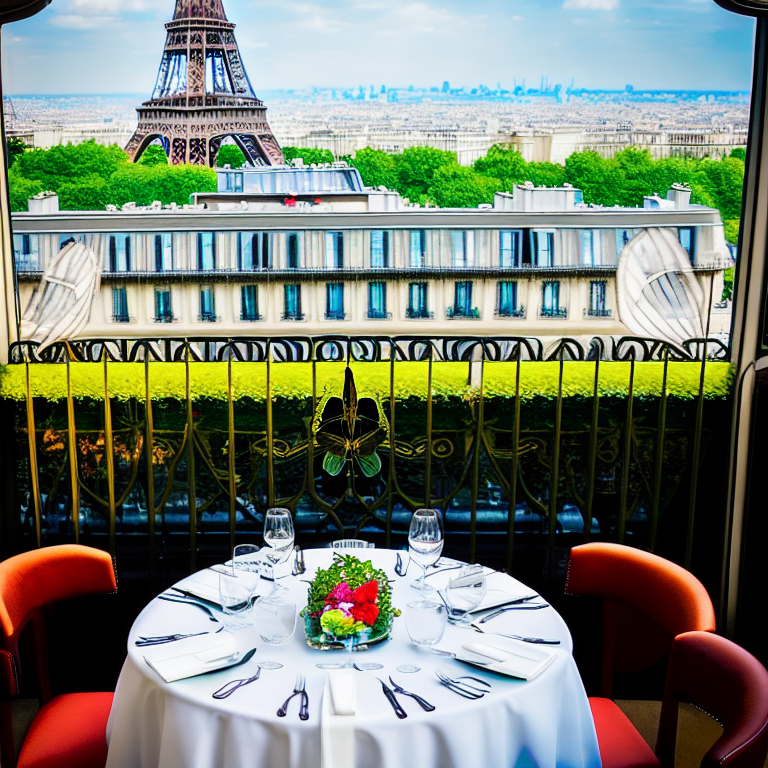
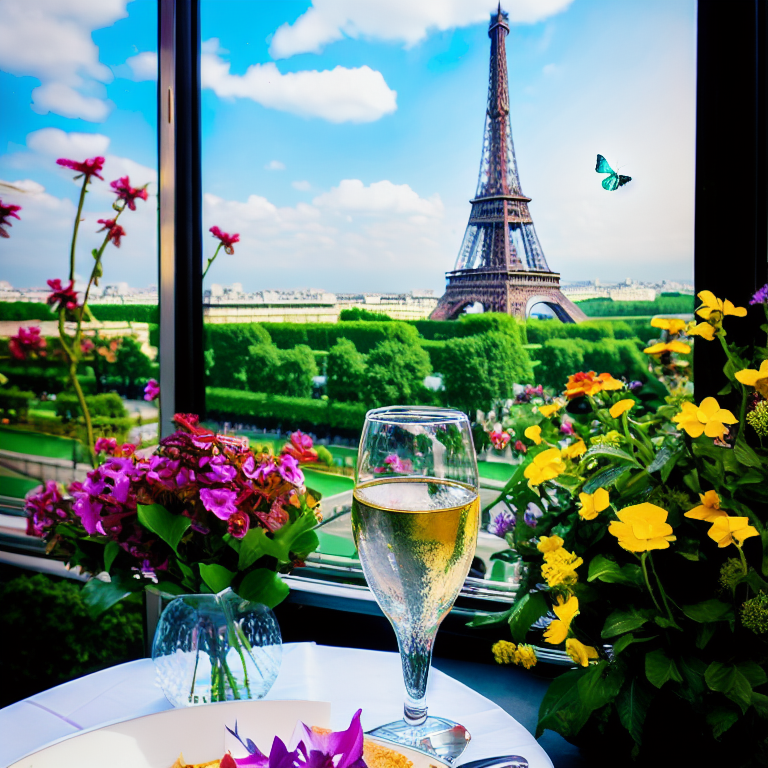

'Seed: 565376493'

In [7]:
prompt = "a photo of butterfly fine dining with a view to the Eiffel Tower"
remove_safety = False
num_images = 4
seed = random.randint(0, 2147483647)

if remove_safety:
  negative_prompt = None
  pipe.safety_checker = None
else:
  negative_prompt = "nude, naked"

images = pipe(
    prompt,
    height = image_length,
    width = image_length,
    num_inference_steps = 25,
    guidance_scale = 9,
    num_images_per_prompt = num_images,
    negative_prompt = negative_prompt,
    generator = torch.Generator("cuda").manual_seed(seed)
    ).images

media.show_images(images)
display(f"Seed: {seed}")
images[0].save("output.jpg")